In [1]:
import os
import sys
import copy
import pathlib
import time
import random
import easydict

import torch
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
import numpy as np
from glob import glob
from tqdm import tqdm

os.environ["CUDA_VISIBLE_DEVICES"]='1, 2'

In [2]:
from dataloader.handhygiene import HandHygiene
# from dataloader.handhygiene import BalancedBatchSampler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import MultiStepLR
from train import get_models

from tensorboardX import SummaryWriter
from spatial_transforms import Compose
from spatial_transforms import Normalize
from spatial_transforms import Scale
from spatial_transforms import CenterCrop
from spatial_transforms import RandomHorizontalFlip
from spatial_transforms import RandomAffine
from spatial_transforms import RandomRotation
from spatial_transforms import ColorJitter
from spatial_transforms import ToTensor 
from temporal_transforms import TemporalRandomChoice
from temporal_transforms import TemporalRandomCrop
from temporal_transforms import LoopPadding, MirrorPadding, MirrorLoopPadding
from openpose_transforms import MultiScaleTorsoRandomCrop

In [10]:
# len_clip, batch, step, lr, w_decay, epoch, start_epoch = 16, 384, 3, 1e-4, 1e-7, 100, 0 #20200404_iclr_softmax/
# len_clip, batch, step, lr, w_decay, epoch, start_epoch = 16, 256, 3, 1e-2, 1e-3, 100, 0 #20200720
args = easydict.EasyDict({"workers": 4, 
                          "epochs": 100, 
                          "start_epoch": 0,
                          "clip_len": 16,
                          "batch_size": 256,
                          "lr": 1e-3,
                          "momentum": 0.9,
                          "weight_decay": 1e-4,
                          "world_size": 1,
                          "rank": 1,
                          "seed": 100,
                          "gpu": None,
                          "dist_backend": "nccl",
                          "multiprocessing": True,
                          "multiprocessing_distributed": False
                         })

random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.deterministic = True
cudnn.benchmark = False

In [4]:
VIDEO_DIR='./data/images_new' #./data/videos

STEPS = {'touching_equipment': 1,
        'rubbing_hands': 1,
#         'wearing_gloves': 1,
        'other_action': 3}

IMG_SIZE = 224
MEAN = [110.2008, 100.63983, 95.99475]
STD = [58.14765, 56.46975, 55.332195]

scales = np.linspace(0.75, 1.1, num=1000)
# center =((1+1.2)/2)
center = 1

openpose_transform = {
    'train':MultiScaleTorsoRandomCrop(scales, IMG_SIZE),
    'val':MultiScaleTorsoRandomCrop(np.linspace(center, center, num=1), 
                                    IMG_SIZE, centercrop=True)
}

spatial_transform = {
    'train': Compose([Scale(IMG_SIZE),
                      CenterCrop(IMG_SIZE),
                      RandomHorizontalFlip(),
                      ColorJitter(brightness=0.1),
                      ToTensor(1), 
                      Normalize(MEAN, STD)
    ]),
    'val': Compose([Scale(IMG_SIZE), 
                    CenterCrop(IMG_SIZE), 
                    ToTensor(1), 
                    Normalize(MEAN, STD)
    ])}

temporal_transform = {'train':Compose([
                    LoopPadding(args.clip_len)
]),
                     'val':LoopPadding(args.clip_len)}

dataset = {
    'train': HandHygiene(os.path.join(VIDEO_DIR, 'train'), 
                          frames_per_clip=args.clip_len,
                          step_between_clips=STEPS,
                          opt_flow_preprocess=False,
                          temporal_transform=temporal_transform['train'],
                          openpose_transform=openpose_transform['train'],
                          spatial_transform=spatial_transform['train']
                        ),
    'val': HandHygiene(os.path.join(VIDEO_DIR, 'val'),
                       frames_per_clip=args.clip_len,
                       step_between_clips=STEPS,
                       opt_flow_preprocess=False,
                       temporal_transform=temporal_transform['val'],
                       openpose_transform=openpose_transform['val'],
                       spatial_transform=spatial_transform['val']
                      ),
}


Training for classes rubbing_hands, touching_equipment, other_action


100%|██████████| 13/13 [00:00<00:00, 46.61it/s]


Number of ./data/images_new/train video clips: 8675 (8272 images)
Number of clips:  {'rubbing_hands': 2794, 'touching_equipment': 2958, 'other_action': 2923}
Number of frames:  {'rubbing_hands': 5557, 'touching_equipment': 3961, 'other_action': 13494}


  0%|          | 0/3 [00:00<?, ?it/s]

Total number of frames: {'rubbing_hands': 176542, 'touching_equipment': 383560, 'other_action': 327184}
Training for classes rubbing_hands, touching_equipment, other_action


100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


Number of ./data/images_new/val video clips: 1453 (1668 images)
Number of clips:  {'rubbing_hands': 507, 'touching_equipment': 467, 'other_action': 479}
Number of frames:  {'rubbing_hands': 818, 'touching_equipment': 790, 'other_action': 2294}
Total number of frames: {'rubbing_hands': 35118, 'touching_equipment': 30733, 'other_action': 30329}


# Feeding dataset

In [5]:
if args.multiprocessing:
    manager = mp.Manager()
args['dataset']=dataset

[RGB] Filling cache for index 38
[Flow] Filling cache for index 38


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


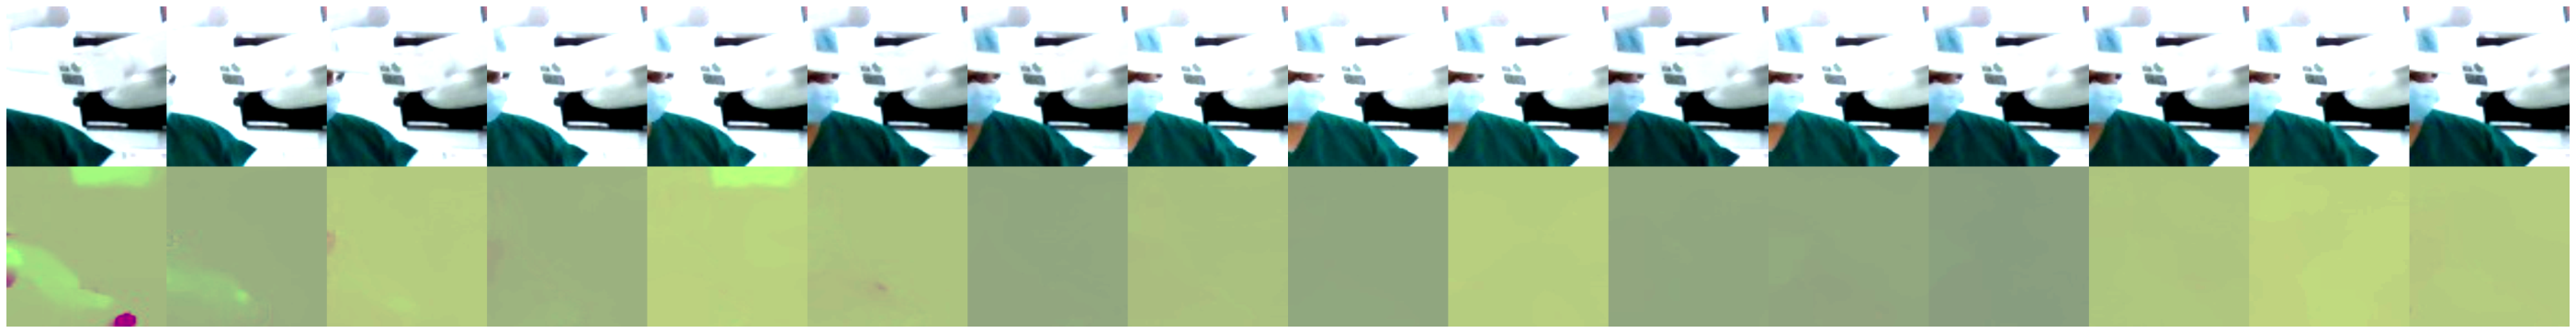

tensor(2)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_dataset(items): # item: C x D x 244 x 244
    
    rgbs = items[0].transpose(0, 1)
    flows = items[1].transpose(0, 1)
    label = items[2]
    n = len(rgbs)
    shape = np.asarray(flows[0]).shape
    rgb = np.hstack((np.asarray(rgb).transpose(1, 2, 0)+1)/2 for rgb in rgbs)
    tmp = np.zeros((shape[1], shape[2], 1))
    flow = np.hstack((np.dstack((np.asarray(flow).transpose(1, 2, 0), tmp))+1)/2 for flow in flows)

    img = np.vstack((rgb, flow))
    plt.figure(figsize=(50, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(label)
        #print('CLEAN' if item[2].item() == 0 else 'NOTCLEAN')
    
i=1000
phase='train'
show_dataset(dataset[phase][i])
(vidx, idx, person_idx, cidx, label), video_c = dataset[phase].video_clips.get_clip_location(i)
video_path = dataset[phase].video_clips.video_paths[vidx]


# Training

In [7]:
dataset = args.dataset
num_classes = len(dataset['train'].classes)

# create model 
i3d_rgb, i3d_flow = get_models(num_classes, True, 170, load_pt_weights=True)
i3d_rgb = torch.nn.DataParallel(i3d_rgb).cuda()
i3d_flow = torch.nn.DataParallel(i3d_flow).cuda()

# hyperparameters / trainable parameters
optims={'rgb':None, 'flow':None}
schedulers = {'rgb':None, 'flow':None}
feature_extract=True


def trainable_params(model, mode='rgb'):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    optims[mode] = torch.optim.SGD(model.parameters(), lr=args.lr, 
                                   momentum=args.momentum,
                                   weight_decay=args.weight_decay)

trainable_params(i3d_rgb, 'rgb')
trainable_params(i3d_flow, 'flow')
schedulers['rgb'] = MultiStepLR(optims['rgb'], milestones=[10], gamma=0.1)
schedulers['flow'] = MultiStepLR(optims['flow'], milestones=[10], gamma=0.1)

criterion = F.cross_entropy

dataloaders = {
        phase: DataLoader(
            dataset[phase], 
            shuffle=True if phase == 'train' else False,
            num_workers=args.workers, 
            #pin_memory=True, 
            batch_size=args.batch_size if phase=='train' else 1,
        )
        for phase in ['train', 'val']
    }
    


loading rgb weight from model/model_rgb.pth ....
loading flow weight from model/model_flow.pth ....
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias
Params to learn:
	 module.conv3d_0c_1x1.0.conv3d.weight
	 module.conv3d_0c_1x1.0.conv3d.bias
	 module.conv3d_0c_1x1.1.conv3d.weight
	 module.conv3d_0c_1x1.1.conv3d.bias


# Training

In [8]:
from train import train

In [9]:
train((i3d_rgb, i3d_flow), 
          dataloaders, optims, 
          criterion,
          schedulers,
          args.epochs, 
          args.start_epoch,
          manager)

  0%|          | 0/207 [00:00<?, ?it/s]

setting manager....
mp manager initialized....
setting manager....
mp manager initialized....



  0%|          | 1/207 [00:00<03:12,  1.07it/s]

[RGB] Filling cache for index 0



  1%|          | 2/207 [00:01<02:37,  1.30it/s]

[RGB] Filling cache for index 1



  1%|▏         | 3/207 [00:01<02:17,  1.48it/s]

[RGB] Filling cache for index 2



  2%|▏         | 4/207 [00:02<02:14,  1.51it/s]

[RGB] Filling cache for index 3



  2%|▏         | 5/207 [00:03<02:41,  1.25it/s]

[RGB] Filling cache for index 4



  3%|▎         | 6/207 [00:04<02:28,  1.35it/s]

[RGB] Filling cache for index 5



  3%|▎         | 7/207 [00:04<02:21,  1.42it/s]

[RGB] Filling cache for index 6



  4%|▍         | 8/207 [00:05<02:05,  1.58it/s]

[RGB] Filling cache for index 7



  4%|▍         | 9/207 [00:05<02:07,  1.56it/s]

[RGB] Filling cache for index 8



  5%|▍         | 10/207 [00:06<01:57,  1.68it/s]

[RGB] Filling cache for index 9



  5%|▌         | 11/207 [00:07<02:02,  1.60it/s]

[RGB] Filling cache for index 10



  6%|▌         | 12/207 [00:10<04:47,  1.47s/it]

[RGB] Filling cache for index 11



  6%|▋         | 13/207 [00:11<04:22,  1.35s/it]

[RGB] Filling cache for index 12



  7%|▋         | 14/207 [00:12<03:27,  1.08s/it]

[RGB] Filling cache for index 13



  7%|▋         | 15/207 [00:12<02:47,  1.14it/s]

[RGB] Filling cache for index 14



  8%|▊         | 16/207 [00:12<02:12,  1.44it/s]

[RGB] Filling cache for index 15



  8%|▊         | 17/207 [00:13<01:54,  1.66it/s]

[RGB] Filling cache for index 16



  9%|▊         | 18/207 [00:13<01:45,  1.79it/s]

[RGB] Filling cache for index 17



  9%|▉         | 19/207 [00:14<01:48,  1.73it/s]

[RGB] Filling cache for index 18



 10%|▉         | 20/207 [00:14<01:40,  1.86it/s]

[RGB] Filling cache for index 19



 10%|█         | 21/207 [00:15<01:33,  1.98it/s]

[RGB] Filling cache for index 20



 11%|█         | 22/207 [00:15<01:34,  1.96it/s]

[RGB] Filling cache for index 21



 11%|█         | 23/207 [00:15<01:28,  2.08it/s]

[RGB] Filling cache for index 22



 12%|█▏        | 24/207 [00:16<01:31,  2.01it/s]

[RGB] Filling cache for index 23



 12%|█▏        | 25/207 [00:16<01:25,  2.12it/s]

[RGB] Filling cache for index 24



 13%|█▎        | 26/207 [00:17<01:14,  2.43it/s]

[RGB] Filling cache for index 25



 13%|█▎        | 27/207 [00:17<01:15,  2.37it/s]

[RGB] Filling cache for index 26



 14%|█▎        | 28/207 [00:18<01:31,  1.96it/s]

[RGB] Filling cache for index 27



 14%|█▍        | 29/207 [00:18<01:23,  2.13it/s]

[RGB] Filling cache for index 28



 14%|█▍        | 30/207 [00:19<01:20,  2.21it/s]

[RGB] Filling cache for index 29



 15%|█▌        | 32/207 [00:19<01:05,  2.66it/s]

[RGB] Filling cache for index 30
[RGB] Filling cache for index 31



 16%|█▌        | 33/207 [00:20<01:12,  2.40it/s]

[RGB] Filling cache for index 32



 16%|█▋        | 34/207 [00:21<01:43,  1.68it/s]

[RGB] Filling cache for index 33



 17%|█▋        | 35/207 [00:21<01:31,  1.88it/s]

[RGB] Filling cache for index 34



 17%|█▋        | 36/207 [00:22<01:34,  1.82it/s]

[RGB] Filling cache for index 35



 18%|█▊        | 37/207 [00:22<01:24,  2.00it/s]

[RGB] Filling cache for index 36



 18%|█▊        | 38/207 [00:24<02:09,  1.30it/s]

[RGB] Filling cache for index 37



 19%|█▉        | 39/207 [00:24<01:54,  1.47it/s]

[RGB] Filling cache for index 38



 19%|█▉        | 40/207 [00:25<01:46,  1.57it/s]

[RGB] Filling cache for index 39



 20%|█▉        | 41/207 [00:25<01:27,  1.90it/s]

[RGB] Filling cache for index 40



 20%|██        | 42/207 [00:25<01:20,  2.05it/s]

[RGB] Filling cache for index 41



 21%|██        | 43/207 [00:26<01:16,  2.15it/s]

[RGB] Filling cache for index 42



 21%|██▏       | 44/207 [00:26<01:10,  2.31it/s]

[RGB] Filling cache for index 43



 22%|██▏       | 45/207 [00:27<01:18,  2.06it/s]

[RGB] Filling cache for index 44



 22%|██▏       | 46/207 [00:27<01:16,  2.10it/s]

[RGB] Filling cache for index 45



 23%|██▎       | 47/207 [00:28<01:20,  1.98it/s]

[RGB] Filling cache for index 46



 23%|██▎       | 48/207 [00:28<01:34,  1.68it/s]

[RGB] Filling cache for index 47



 24%|██▎       | 49/207 [00:29<01:31,  1.74it/s]

[RGB] Filling cache for index 48



 24%|██▍       | 50/207 [00:29<01:19,  1.98it/s]

[RGB] Filling cache for index 49



 25%|██▍       | 51/207 [00:31<01:49,  1.43it/s]

[RGB] Filling cache for index 50



 25%|██▌       | 52/207 [00:31<01:51,  1.40it/s]

[RGB] Filling cache for index 51



 26%|██▌       | 53/207 [00:32<01:44,  1.47it/s]

[RGB] Filling cache for index 52



 26%|██▌       | 54/207 [00:33<01:45,  1.45it/s]

[RGB] Filling cache for index 53



 27%|██▋       | 55/207 [00:33<01:46,  1.43it/s]

[RGB] Filling cache for index 54



 27%|██▋       | 56/207 [00:34<01:38,  1.53it/s]

[RGB] Filling cache for index 55



 28%|██▊       | 57/207 [00:34<01:36,  1.55it/s]

[RGB] Filling cache for index 56



 28%|██▊       | 58/207 [00:35<01:28,  1.69it/s]

[RGB] Filling cache for index 57



 29%|██▊       | 59/207 [00:37<02:35,  1.05s/it]

[RGB] Filling cache for index 58



 29%|██▉       | 60/207 [00:38<02:25,  1.01it/s]

[RGB] Filling cache for index 59



 29%|██▉       | 61/207 [00:39<02:14,  1.09it/s]

[RGB] Filling cache for index 60
[RGB] Filling cache for index 61



 30%|███       | 63/207 [00:39<01:31,  1.57it/s]

[RGB] Filling cache for index 62



 31%|███       | 64/207 [00:40<01:17,  1.84it/s]

[RGB] Filling cache for index 63



 31%|███▏      | 65/207 [00:40<01:11,  1.99it/s]

[RGB] Filling cache for index 64



 32%|███▏      | 66/207 [00:40<01:03,  2.22it/s]

[RGB] Filling cache for index 65



 32%|███▏      | 67/207 [00:41<01:02,  2.25it/s]

[RGB] Filling cache for index 66



 33%|███▎      | 68/207 [00:41<00:55,  2.49it/s]

[RGB] Filling cache for index 67



 33%|███▎      | 69/207 [00:42<01:05,  2.11it/s]

[RGB] Filling cache for index 68



 34%|███▍      | 70/207 [00:42<01:12,  1.89it/s]

[RGB] Filling cache for index 69



 34%|███▍      | 71/207 [00:43<01:10,  1.92it/s]

[RGB] Filling cache for index 70



 35%|███▍      | 72/207 [00:44<01:13,  1.84it/s]

[RGB] Filling cache for index 71



 35%|███▌      | 73/207 [00:44<01:06,  2.02it/s]

[RGB] Filling cache for index 72



 36%|███▌      | 74/207 [00:44<01:02,  2.12it/s]

[RGB] Filling cache for index 73
[RGB] Filling cache for index 74



 37%|███▋      | 76/207 [00:45<00:47,  2.74it/s]

[RGB] Filling cache for index 75



 37%|███▋      | 77/207 [00:46<01:01,  2.13it/s]

[RGB] Filling cache for index 76



 38%|███▊      | 78/207 [00:47<01:31,  1.41it/s]

[RGB] Filling cache for index 77



 38%|███▊      | 79/207 [00:48<01:45,  1.21it/s]

[RGB] Filling cache for index 78



 39%|███▊      | 80/207 [00:50<02:30,  1.19s/it]

[RGB] Filling cache for index 79



 39%|███▉      | 81/207 [00:51<02:19,  1.10s/it]

[RGB] Filling cache for index 80



 40%|███▉      | 82/207 [00:52<02:22,  1.14s/it]

[RGB] Filling cache for index 81



 40%|████      | 83/207 [00:57<04:24,  2.13s/it]

[RGB] Filling cache for index 82



 41%|████      | 84/207 [01:00<04:58,  2.43s/it]

[RGB] Filling cache for index 83



 41%|████      | 85/207 [01:00<03:42,  1.82s/it]

[RGB] Filling cache for index 84



 42%|████▏     | 86/207 [01:01<02:57,  1.47s/it]

[RGB] Filling cache for index 85



 42%|████▏     | 87/207 [01:01<02:16,  1.14s/it]

[RGB] Filling cache for index 86



 43%|████▎     | 88/207 [01:02<02:16,  1.14s/it]

[RGB] Filling cache for index 87



 43%|████▎     | 89/207 [01:03<01:52,  1.05it/s]

[RGB] Filling cache for index 88



 43%|████▎     | 90/207 [01:03<01:45,  1.11it/s]

[RGB] Filling cache for index 89



 44%|████▍     | 91/207 [01:04<01:39,  1.16it/s]

[RGB] Filling cache for index 90



 44%|████▍     | 92/207 [01:05<01:21,  1.41it/s]

[RGB] Filling cache for index 91



 45%|████▍     | 93/207 [01:05<01:09,  1.63it/s]

[RGB] Filling cache for index 92



 45%|████▌     | 94/207 [01:05<00:59,  1.90it/s]

[RGB] Filling cache for index 93



 46%|████▌     | 95/207 [01:08<02:00,  1.08s/it]

[RGB] Filling cache for index 94



 46%|████▋     | 96/207 [01:09<02:18,  1.24s/it]

[RGB] Filling cache for index 95



 47%|████▋     | 97/207 [01:11<02:33,  1.40s/it]

[RGB] Filling cache for index 96



 47%|████▋     | 98/207 [01:17<05:07,  2.82s/it]

[RGB] Filling cache for index 97



 48%|████▊     | 99/207 [01:19<04:43,  2.63s/it]

[RGB] Filling cache for index 98



 48%|████▊     | 100/207 [01:20<03:35,  2.02s/it]

[RGB] Filling cache for index 99



 49%|████▉     | 101/207 [01:22<03:43,  2.11s/it]

[RGB] Filling cache for index 100



 49%|████▉     | 102/207 [01:23<02:44,  1.57s/it]

[RGB] Filling cache for index 101



 50%|████▉     | 103/207 [01:23<02:12,  1.28s/it]

[RGB] Filling cache for index 102



 50%|█████     | 104/207 [01:24<01:51,  1.08s/it]

[RGB] Filling cache for index 103



 51%|█████     | 105/207 [01:25<02:00,  1.18s/it]

[RGB] Filling cache for index 104



 51%|█████     | 106/207 [01:27<02:14,  1.33s/it]

[RGB] Filling cache for index 105



 52%|█████▏    | 107/207 [01:30<02:55,  1.76s/it]

[RGB] Filling cache for index 106



 52%|█████▏    | 108/207 [01:31<02:37,  1.59s/it]

[RGB] Filling cache for index 107



 53%|█████▎    | 109/207 [01:32<02:30,  1.53s/it]

[RGB] Filling cache for index 108



 53%|█████▎    | 110/207 [01:34<02:24,  1.48s/it]

[RGB] Filling cache for index 109



 54%|█████▎    | 111/207 [01:34<01:53,  1.18s/it]

[RGB] Filling cache for index 110



 54%|█████▍    | 112/207 [01:35<01:34,  1.00it/s]

[RGB] Filling cache for index 111



 55%|█████▍    | 113/207 [01:36<01:43,  1.10s/it]

[RGB] Filling cache for index 112



 55%|█████▌    | 114/207 [01:36<01:20,  1.16it/s]

[RGB] Filling cache for index 113



 56%|█████▌    | 115/207 [01:38<01:38,  1.07s/it]

[RGB] Filling cache for index 114



 56%|█████▌    | 116/207 [01:39<01:25,  1.07it/s]

[RGB] Filling cache for index 115



 57%|█████▋    | 117/207 [01:39<01:14,  1.20it/s]

[RGB] Filling cache for index 116



 57%|█████▋    | 118/207 [01:40<01:01,  1.44it/s]

[RGB] Filling cache for index 117



 57%|█████▋    | 119/207 [01:40<00:56,  1.56it/s]

[RGB] Filling cache for index 118



 58%|█████▊    | 120/207 [01:40<00:47,  1.84it/s]

[RGB] Filling cache for index 119



 58%|█████▊    | 121/207 [01:42<01:20,  1.07it/s]

[RGB] Filling cache for index 120



 59%|█████▉    | 122/207 [01:43<01:04,  1.32it/s]

[RGB] Filling cache for index 121



 59%|█████▉    | 123/207 [01:43<00:53,  1.56it/s]

[RGB] Filling cache for index 122



 60%|█████▉    | 124/207 [01:44<01:15,  1.10it/s]

[RGB] Filling cache for index 123



 60%|██████    | 125/207 [01:45<00:59,  1.39it/s]

[RGB] Filling cache for index 124



 61%|██████    | 126/207 [01:46<01:01,  1.32it/s]

[RGB] Filling cache for index 125



 61%|██████▏   | 127/207 [01:47<01:14,  1.08it/s]

[RGB] Filling cache for index 126



 62%|██████▏   | 128/207 [01:48<01:09,  1.13it/s]

[RGB] Filling cache for index 127



 62%|██████▏   | 129/207 [01:50<01:36,  1.24s/it]

[RGB] Filling cache for index 128



 63%|██████▎   | 130/207 [01:51<01:29,  1.16s/it]

[RGB] Filling cache for index 129



 63%|██████▎   | 131/207 [01:51<01:09,  1.09it/s]

[RGB] Filling cache for index 130



 64%|██████▍   | 132/207 [01:53<01:38,  1.32s/it]

[RGB] Filling cache for index 131



 64%|██████▍   | 133/207 [01:54<01:17,  1.04s/it]

[RGB] Filling cache for index 132



 65%|██████▍   | 134/207 [01:54<01:04,  1.13it/s]

[RGB] Filling cache for index 133



 65%|██████▌   | 135/207 [01:55<00:59,  1.21it/s]

[RGB] Filling cache for index 134



 66%|██████▌   | 136/207 [01:56<01:03,  1.12it/s]

[RGB] Filling cache for index 135



 66%|██████▌   | 137/207 [01:57<00:55,  1.27it/s]

[RGB] Filling cache for index 136



 67%|██████▋   | 138/207 [01:57<00:55,  1.25it/s]

[RGB] Filling cache for index 137



 67%|██████▋   | 139/207 [01:58<00:45,  1.48it/s]

[RGB] Filling cache for index 138



 68%|██████▊   | 140/207 [01:58<00:41,  1.60it/s]

[RGB] Filling cache for index 139



 68%|██████▊   | 141/207 [01:59<00:36,  1.81it/s]

[RGB] Filling cache for index 140



 69%|██████▊   | 142/207 [01:59<00:37,  1.75it/s]

[RGB] Filling cache for index 141



 69%|██████▉   | 143/207 [02:01<00:53,  1.19it/s]

[RGB] Filling cache for index 142



 70%|██████▉   | 144/207 [02:01<00:50,  1.24it/s]

[RGB] Filling cache for index 143



 70%|███████   | 145/207 [02:02<00:46,  1.35it/s]

[RGB] Filling cache for index 144



 71%|███████   | 146/207 [02:03<00:42,  1.45it/s]

[RGB] Filling cache for index 145



 71%|███████   | 147/207 [02:03<00:38,  1.57it/s]

[RGB] Filling cache for index 146



 71%|███████▏  | 148/207 [02:04<00:46,  1.27it/s]

[RGB] Filling cache for index 147



 72%|███████▏  | 149/207 [02:05<00:42,  1.37it/s]

[RGB] Filling cache for index 148



 72%|███████▏  | 150/207 [02:05<00:35,  1.62it/s]

[RGB] Filling cache for index 149



 73%|███████▎  | 151/207 [02:06<00:31,  1.76it/s]

[RGB] Filling cache for index 150



 73%|███████▎  | 152/207 [02:06<00:28,  1.91it/s]

[RGB] Filling cache for index 151



 74%|███████▍  | 154/207 [02:07<00:23,  2.27it/s]

[RGB] Filling cache for index 152
[RGB] Filling cache for index 153



 75%|███████▍  | 155/207 [02:08<00:27,  1.89it/s]

[RGB] Filling cache for index 154



 75%|███████▌  | 156/207 [02:08<00:29,  1.70it/s]

[RGB] Filling cache for index 155



 76%|███████▌  | 157/207 [02:11<01:00,  1.21s/it]

[RGB] Filling cache for index 156



 76%|███████▋  | 158/207 [02:12<01:03,  1.29s/it]

[RGB] Filling cache for index 157



 77%|███████▋  | 159/207 [02:13<00:47,  1.01it/s]

[RGB] Filling cache for index 158



 77%|███████▋  | 160/207 [02:15<01:01,  1.30s/it]

[RGB] Filling cache for index 159



 78%|███████▊  | 161/207 [02:16<00:55,  1.22s/it]

[RGB] Filling cache for index 160



 78%|███████▊  | 162/207 [02:17<00:49,  1.11s/it]

[RGB] Filling cache for index 161



 79%|███████▊  | 163/207 [02:20<01:17,  1.76s/it]

[RGB] Filling cache for index 162



 79%|███████▉  | 164/207 [02:22<01:22,  1.93s/it]

[RGB] Filling cache for index 163



 80%|███████▉  | 165/207 [02:23<01:09,  1.66s/it]

[RGB] Filling cache for index 164



 80%|████████  | 166/207 [02:24<00:59,  1.44s/it]

[RGB] Filling cache for index 165



 81%|████████  | 167/207 [02:25<00:50,  1.27s/it]

[RGB] Filling cache for index 166



 81%|████████  | 168/207 [02:26<00:40,  1.03s/it]

[RGB] Filling cache for index 167



 82%|████████▏ | 169/207 [02:27<00:47,  1.25s/it]

[RGB] Filling cache for index 168



 82%|████████▏ | 170/207 [02:28<00:38,  1.05s/it]

[RGB] Filling cache for index 169



 83%|████████▎ | 171/207 [02:29<00:42,  1.19s/it]

[RGB] Filling cache for index 170



 83%|████████▎ | 172/207 [02:31<00:41,  1.19s/it]

[RGB] Filling cache for index 171



 84%|████████▎ | 173/207 [02:31<00:36,  1.09s/it]

[RGB] Filling cache for index 172



 84%|████████▍ | 174/207 [02:32<00:29,  1.12it/s]

[RGB] Filling cache for index 173



 85%|████████▍ | 175/207 [02:33<00:34,  1.08s/it]

[RGB] Filling cache for index 174



 85%|████████▌ | 176/207 [02:35<00:38,  1.26s/it]

[RGB] Filling cache for index 175



 86%|████████▌ | 177/207 [02:36<00:31,  1.05s/it]

[RGB] Filling cache for index 176



 86%|████████▌ | 178/207 [02:36<00:24,  1.17it/s]

[RGB] Filling cache for index 177



 86%|████████▋ | 179/207 [02:36<00:20,  1.40it/s]

[RGB] Filling cache for index 178



 87%|████████▋ | 180/207 [02:37<00:21,  1.27it/s]

[RGB] Filling cache for index 179



 87%|████████▋ | 181/207 [02:38<00:18,  1.42it/s]

[RGB] Filling cache for index 180



 88%|████████▊ | 182/207 [02:39<00:18,  1.39it/s]

[RGB] Filling cache for index 181



 88%|████████▊ | 183/207 [02:39<00:14,  1.71it/s]

[RGB] Filling cache for index 182



 89%|████████▉ | 184/207 [02:39<00:12,  1.85it/s]

[RGB] Filling cache for index 183



 89%|████████▉ | 185/207 [02:40<00:11,  1.86it/s]

[RGB] Filling cache for index 184



 90%|████████▉ | 186/207 [02:40<00:10,  1.92it/s]

[RGB] Filling cache for index 185



 90%|█████████ | 187/207 [02:41<00:09,  2.13it/s]

[RGB] Filling cache for index 186



 91%|█████████ | 188/207 [02:42<00:15,  1.24it/s]

[RGB] Filling cache for index 187



 91%|█████████▏| 189/207 [02:43<00:16,  1.12it/s]

[RGB] Filling cache for index 188



 92%|█████████▏| 190/207 [02:44<00:13,  1.26it/s]

[RGB] Filling cache for index 189



 92%|█████████▏| 191/207 [02:45<00:11,  1.37it/s]

[RGB] Filling cache for index 190



 93%|█████████▎| 192/207 [02:47<00:20,  1.36s/it]

[RGB] Filling cache for index 191



 93%|█████████▎| 193/207 [02:49<00:19,  1.38s/it]

[RGB] Filling cache for index 192



 94%|█████████▎| 194/207 [02:54<00:34,  2.62s/it]

[RGB] Filling cache for index 193



 94%|█████████▍| 195/207 [02:55<00:24,  2.01s/it]

[RGB] Filling cache for index 194



 95%|█████████▍| 196/207 [02:56<00:17,  1.61s/it]

[RGB] Filling cache for index 195



 96%|█████████▌| 198/207 [02:56<00:08,  1.09it/s]

[RGB] Filling cache for index 196
[RGB] Filling cache for index 197



 96%|█████████▌| 199/207 [02:58<00:09,  1.15s/it]

[RGB] Filling cache for index 198



 97%|█████████▋| 200/207 [02:58<00:06,  1.09it/s]

[RGB] Filling cache for index 199



 97%|█████████▋| 201/207 [03:00<00:06,  1.06s/it]

[RGB] Filling cache for index 200



 98%|█████████▊| 202/207 [03:01<00:06,  1.21s/it]

[RGB] Filling cache for index 201



 98%|█████████▊| 203/207 [03:03<00:05,  1.38s/it]

[RGB] Filling cache for index 202



 99%|█████████▊| 204/207 [03:03<00:03,  1.06s/it]

[RGB] Filling cache for index 203



 99%|█████████▉| 205/207 [03:04<00:02,  1.07s/it]

[RGB] Filling cache for index 204



100%|█████████▉| 206/207 [03:05<00:00,  1.14it/s]

[RGB] Filling cache for index 205



100%|██████████| 207/207 [03:06<00:00,  1.11it/s]

  0%|          | 0/207 [00:00<?, ?it/s]

[RGB] Filling cache for index 206



  0%|          | 1/207 [00:00<01:54,  1.79it/s]

[Flow] Filling cache for index 0



  1%|          | 2/207 [00:00<01:38,  2.09it/s]

[Flow] Filling cache for index 1



  1%|▏         | 3/207 [00:01<01:30,  2.25it/s]

[Flow] Filling cache for index 2



  2%|▏         | 5/207 [00:01<01:06,  3.02it/s]

[Flow] Filling cache for index 3
[Flow] Filling cache for index 4



  3%|▎         | 6/207 [00:02<01:07,  2.96it/s]

[Flow] Filling cache for index 5



  3%|▎         | 7/207 [00:02<01:12,  2.77it/s]

[Flow] Filling cache for index 6



  4%|▍         | 8/207 [00:02<01:13,  2.70it/s]

[Flow] Filling cache for index 7



  4%|▍         | 9/207 [00:03<01:04,  3.05it/s]

[Flow] Filling cache for index 8



  5%|▍         | 10/207 [00:03<01:04,  3.06it/s]

[Flow] Filling cache for index 9



  5%|▌         | 11/207 [00:03<01:16,  2.55it/s]

[Flow] Filling cache for index 10



  6%|▌         | 12/207 [00:06<03:24,  1.05s/it]

[Flow] Filling cache for index 11



  7%|▋         | 14/207 [00:07<02:02,  1.58it/s]

[Flow] Filling cache for index 12
[Flow] Filling cache for index 13



  7%|▋         | 15/207 [00:07<01:38,  1.96it/s]

[Flow] Filling cache for index 14



  8%|▊         | 16/207 [00:07<01:28,  2.16it/s]

[Flow] Filling cache for index 15



  8%|▊         | 17/207 [00:07<01:21,  2.34it/s]


[Flow] Filling cache for index 16
[Flow] Filling cache for index 17


  9%|▉         | 19/207 [00:08<01:10,  2.68it/s]

[Flow] Filling cache for index 18



 10%|▉         | 20/207 [00:08<01:08,  2.72it/s]

[Flow] Filling cache for index 19
[Flow] Filling cache for index 20



 11%|█         | 22/207 [00:09<01:05,  2.82it/s]

[Flow] Filling cache for index 21



 11%|█         | 23/207 [00:09<01:03,  2.91it/s]

[Flow] Filling cache for index 22



 12%|█▏        | 24/207 [00:10<01:06,  2.74it/s]

[Flow] Filling cache for index 23



 12%|█▏        | 25/207 [00:10<01:09,  2.61it/s]

[Flow] Filling cache for index 24



 13%|█▎        | 26/207 [00:11<01:14,  2.43it/s]

[Flow] Filling cache for index 25



 13%|█▎        | 27/207 [00:11<01:12,  2.48it/s]

[Flow] Filling cache for index 26



 14%|█▎        | 28/207 [00:11<01:06,  2.70it/s]

[Flow] Filling cache for index 27



 14%|█▍        | 29/207 [00:12<01:01,  2.88it/s]

[Flow] Filling cache for index 28



 14%|█▍        | 30/207 [00:13<02:04,  1.42it/s]

[Flow] Filling cache for index 29



 15%|█▌        | 32/207 [00:14<01:30,  1.93it/s]

[Flow] Filling cache for index 30
[Flow] Filling cache for index 31



 16%|█▌        | 33/207 [00:14<01:31,  1.91it/s]

[Flow] Filling cache for index 32



 16%|█▋        | 34/207 [00:16<02:12,  1.31it/s]

[Flow] Filling cache for index 33



 17%|█▋        | 35/207 [00:16<01:58,  1.45it/s]

[Flow] Filling cache for index 34



 17%|█▋        | 36/207 [00:17<01:44,  1.63it/s]

[Flow] Filling cache for index 35



 18%|█▊        | 37/207 [00:17<01:38,  1.73it/s]

[Flow] Filling cache for index 36



 18%|█▊        | 38/207 [00:18<01:38,  1.72it/s]

[Flow] Filling cache for index 37



 19%|█▉        | 39/207 [00:18<01:23,  2.01it/s]

[Flow] Filling cache for index 38



 19%|█▉        | 40/207 [00:19<01:31,  1.82it/s]

[Flow] Filling cache for index 39



 20%|█▉        | 41/207 [00:20<01:55,  1.43it/s]

[Flow] Filling cache for index 40



 20%|██        | 42/207 [00:20<01:35,  1.72it/s]

[Flow] Filling cache for index 41



 21%|██        | 43/207 [00:20<01:22,  2.00it/s]

[Flow] Filling cache for index 42



 21%|██▏       | 44/207 [00:21<01:10,  2.30it/s]

[Flow] Filling cache for index 43



 22%|██▏       | 45/207 [00:21<01:04,  2.53it/s]

[Flow] Filling cache for index 44



 22%|██▏       | 46/207 [00:22<01:07,  2.37it/s]

[Flow] Filling cache for index 45



 23%|██▎       | 47/207 [00:22<01:04,  2.49it/s]

[Flow] Filling cache for index 46



 23%|██▎       | 48/207 [00:23<01:27,  1.81it/s]

[Flow] Filling cache for index 47



 24%|██▎       | 49/207 [00:23<01:12,  2.18it/s]

[Flow] Filling cache for index 48



 24%|██▍       | 50/207 [00:23<01:08,  2.29it/s]

[Flow] Filling cache for index 49



 25%|██▍       | 51/207 [00:24<01:10,  2.22it/s]

[Flow] Filling cache for index 50



 25%|██▌       | 52/207 [00:24<01:08,  2.28it/s]

[Flow] Filling cache for index 51



 26%|██▌       | 53/207 [00:25<01:10,  2.18it/s]

[Flow] Filling cache for index 52



 26%|██▌       | 54/207 [00:25<01:03,  2.42it/s]

[Flow] Filling cache for index 53



 27%|██▋       | 55/207 [00:26<01:03,  2.39it/s]

[Flow] Filling cache for index 54



 27%|██▋       | 56/207 [00:26<00:55,  2.72it/s]

[Flow] Filling cache for index 55



 28%|██▊       | 57/207 [00:26<00:50,  2.94it/s]

[Flow] Filling cache for index 56



 28%|██▊       | 58/207 [00:26<00:48,  3.09it/s]

[Flow] Filling cache for index 57



 29%|██▊       | 59/207 [00:27<00:50,  2.95it/s]

[Flow] Filling cache for index 58



 29%|██▉       | 60/207 [00:27<00:52,  2.80it/s]

[Flow] Filling cache for index 59



 29%|██▉       | 61/207 [00:27<00:49,  2.93it/s]

[Flow] Filling cache for index 60



 30%|██▉       | 62/207 [00:28<00:47,  3.06it/s]

[Flow] Filling cache for index 61



 30%|███       | 63/207 [00:28<00:46,  3.09it/s]

[Flow] Filling cache for index 62



 31%|███       | 64/207 [00:28<00:45,  3.15it/s]

[Flow] Filling cache for index 63
[Flow] Filling cache for index 64



 32%|███▏      | 66/207 [00:29<00:37,  3.80it/s]

[Flow] Filling cache for index 65



 32%|███▏      | 67/207 [00:29<00:39,  3.52it/s]

[Flow] Filling cache for index 66



 33%|███▎      | 68/207 [00:29<00:37,  3.68it/s]

[Flow] Filling cache for index 67



 33%|███▎      | 69/207 [00:30<00:40,  3.40it/s]

[Flow] Filling cache for index 68



 34%|███▍      | 71/207 [00:30<00:42,  3.18it/s]

[Flow] Filling cache for index 69
[Flow] Filling cache for index 70



 35%|███▍      | 72/207 [00:31<00:48,  2.79it/s]

[Flow] Filling cache for index 71
[Flow] Filling cache for index 72



 36%|███▌      | 74/207 [00:31<00:41,  3.23it/s]

[Flow] Filling cache for index 73



 36%|███▌      | 75/207 [00:32<00:41,  3.19it/s]

[Flow] Filling cache for index 74



 37%|███▋      | 76/207 [00:32<00:39,  3.33it/s]

[Flow] Filling cache for index 75



 37%|███▋      | 77/207 [00:32<00:45,  2.85it/s]

[Flow] Filling cache for index 76



 38%|███▊      | 78/207 [00:33<01:08,  1.88it/s]

[Flow] Filling cache for index 77



 38%|███▊      | 79/207 [00:34<01:06,  1.92it/s]

[Flow] Filling cache for index 78



 39%|███▊      | 80/207 [00:36<02:08,  1.01s/it]

[Flow] Filling cache for index 79



 39%|███▉      | 81/207 [00:37<02:06,  1.00s/it]

[Flow] Filling cache for index 80



 40%|███▉      | 82/207 [00:38<01:58,  1.05it/s]

[Flow] Filling cache for index 81



 40%|████      | 83/207 [00:41<03:17,  1.59s/it]

[Flow] Filling cache for index 82



 41%|████      | 84/207 [00:44<04:02,  1.97s/it]

[Flow] Filling cache for index 83



 41%|████      | 85/207 [00:44<02:59,  1.47s/it]

[Flow] Filling cache for index 84



 42%|████▏     | 86/207 [00:45<02:17,  1.14s/it]

[Flow] Filling cache for index 85



 42%|████▏     | 87/207 [00:45<01:46,  1.12it/s]

[Flow] Filling cache for index 86



 43%|████▎     | 88/207 [00:45<01:33,  1.27it/s]

[Flow] Filling cache for index 87



 43%|████▎     | 89/207 [00:46<01:13,  1.60it/s]

[Flow] Filling cache for index 88



 43%|████▎     | 90/207 [00:46<01:01,  1.91it/s]

[Flow] Filling cache for index 89



 44%|████▍     | 91/207 [00:46<00:58,  1.98it/s]

[Flow] Filling cache for index 90



 44%|████▍     | 92/207 [00:47<01:10,  1.63it/s]

[Flow] Filling cache for index 91



 45%|████▍     | 93/207 [00:48<00:58,  1.95it/s]

[Flow] Filling cache for index 92
[Flow] Filling cache for index 93



 46%|████▌     | 95/207 [00:49<01:27,  1.28it/s]

[Flow] Filling cache for index 94



 46%|████▋     | 96/207 [00:51<01:42,  1.08it/s]

[Flow] Filling cache for index 95



 47%|████▋     | 97/207 [00:51<01:32,  1.19it/s]

[Flow] Filling cache for index 96



 47%|████▋     | 98/207 [00:56<03:43,  2.05s/it]

[Flow] Filling cache for index 97



 48%|████▊     | 99/207 [00:58<03:21,  1.87s/it]

[Flow] Filling cache for index 98
[Flow] Filling cache for index 99



 49%|████▉     | 101/207 [00:59<02:09,  1.22s/it]

[Flow] Filling cache for index 100



 49%|████▉     | 102/207 [00:59<01:43,  1.02it/s]

[Flow] Filling cache for index 101



 50%|████▉     | 103/207 [00:59<01:19,  1.30it/s]

[Flow] Filling cache for index 102



 50%|█████     | 104/207 [01:00<01:06,  1.56it/s]

[Flow] Filling cache for index 103



 51%|█████     | 105/207 [01:00<01:03,  1.62it/s]

[Flow] Filling cache for index 104



 51%|█████     | 106/207 [01:01<01:05,  1.54it/s]

[Flow] Filling cache for index 105



 52%|█████▏    | 107/207 [01:03<01:36,  1.03it/s]

[Flow] Filling cache for index 106



 52%|█████▏    | 108/207 [01:03<01:28,  1.11it/s]

[Flow] Filling cache for index 107



 53%|█████▎    | 109/207 [01:04<01:25,  1.15it/s]

[Flow] Filling cache for index 108



 53%|█████▎    | 110/207 [01:05<01:25,  1.14it/s]

[Flow] Filling cache for index 109



 54%|█████▎    | 111/207 [01:05<01:06,  1.45it/s]

[Flow] Filling cache for index 110



 54%|█████▍    | 112/207 [01:06<00:55,  1.70it/s]

[Flow] Filling cache for index 111



 55%|█████▌    | 114/207 [01:07<00:48,  1.92it/s]

[Flow] Filling cache for index 112
[Flow] Filling cache for index 113



 56%|█████▌    | 115/207 [01:07<00:43,  2.12it/s]

[Flow] Filling cache for index 114



 56%|█████▌    | 116/207 [01:07<00:38,  2.33it/s]

[Flow] Filling cache for index 115



 57%|█████▋    | 117/207 [01:08<00:40,  2.23it/s]

[Flow] Filling cache for index 116



 57%|█████▋    | 118/207 [01:08<00:38,  2.31it/s]

[Flow] Filling cache for index 117



 57%|█████▋    | 119/207 [01:09<00:40,  2.15it/s]

[Flow] Filling cache for index 118



 58%|█████▊    | 120/207 [01:09<00:39,  2.21it/s]

[Flow] Filling cache for index 119



 59%|█████▉    | 122/207 [01:11<00:47,  1.78it/s]

[Flow] Filling cache for index 120
[Flow] Filling cache for index 121



 59%|█████▉    | 123/207 [01:11<00:39,  2.11it/s]

[Flow] Filling cache for index 122



 60%|█████▉    | 124/207 [01:12<00:41,  2.00it/s]

[Flow] Filling cache for index 123



 60%|██████    | 125/207 [01:12<00:35,  2.33it/s]

[Flow] Filling cache for index 124



 61%|██████    | 126/207 [01:12<00:35,  2.29it/s]

[Flow] Filling cache for index 125



 61%|██████▏   | 127/207 [01:13<00:35,  2.24it/s]

[Flow] Filling cache for index 126



 62%|██████▏   | 128/207 [01:13<00:37,  2.11it/s]

[Flow] Filling cache for index 127



 62%|██████▏   | 129/207 [01:15<00:52,  1.49it/s]

[Flow] Filling cache for index 128



 63%|██████▎   | 131/207 [01:15<00:36,  2.11it/s]

[Flow] Filling cache for index 129
[Flow] Filling cache for index 130



 64%|██████▍   | 133/207 [01:17<00:44,  1.65it/s]

[Flow] Filling cache for index 131
[Flow] Filling cache for index 132



 65%|██████▍   | 134/207 [01:17<00:40,  1.79it/s]

[Flow] Filling cache for index 133



 65%|██████▌   | 135/207 [01:18<00:38,  1.88it/s]

[Flow] Filling cache for index 134



 66%|██████▌   | 136/207 [01:18<00:38,  1.83it/s]

[Flow] Filling cache for index 135



 66%|██████▌   | 137/207 [01:19<00:32,  2.13it/s]

[Flow] Filling cache for index 136



 67%|██████▋   | 138/207 [01:19<00:37,  1.85it/s]

[Flow] Filling cache for index 137
[Flow] Filling cache for index 138



 68%|██████▊   | 140/207 [01:21<00:49,  1.35it/s]

[Flow] Filling cache for index 139



 68%|██████▊   | 141/207 [01:21<00:41,  1.61it/s]

[Flow] Filling cache for index 140



 69%|██████▊   | 142/207 [01:22<00:37,  1.74it/s]

[Flow] Filling cache for index 141



 69%|██████▉   | 143/207 [01:23<00:44,  1.44it/s]

[Flow] Filling cache for index 142



 70%|██████▉   | 144/207 [01:23<00:37,  1.66it/s]

[Flow] Filling cache for index 143



 70%|███████   | 145/207 [01:23<00:30,  2.01it/s]

[Flow] Filling cache for index 144



 71%|███████   | 146/207 [01:24<00:27,  2.25it/s]

[Flow] Filling cache for index 145



 71%|███████   | 147/207 [01:24<00:27,  2.21it/s]

[Flow] Filling cache for index 146



 71%|███████▏  | 148/207 [01:25<00:30,  1.94it/s]

[Flow] Filling cache for index 147



 72%|███████▏  | 149/207 [01:25<00:28,  2.05it/s]

[Flow] Filling cache for index 148



 72%|███████▏  | 150/207 [01:26<00:25,  2.25it/s]

[Flow] Filling cache for index 149



 73%|███████▎  | 151/207 [01:26<00:25,  2.21it/s]

[Flow] Filling cache for index 150



 73%|███████▎  | 152/207 [01:27<00:34,  1.59it/s]

[Flow] Filling cache for index 151



 74%|███████▍  | 153/207 [01:28<00:29,  1.86it/s]

[Flow] Filling cache for index 152



 74%|███████▍  | 154/207 [01:28<00:23,  2.21it/s]

[Flow] Filling cache for index 153



 75%|███████▍  | 155/207 [01:28<00:22,  2.36it/s]

[Flow] Filling cache for index 154



 75%|███████▌  | 156/207 [01:29<00:21,  2.34it/s]

[Flow] Filling cache for index 155



 76%|███████▌  | 157/207 [01:30<00:38,  1.29it/s]

[Flow] Filling cache for index 156



 77%|███████▋  | 159/207 [01:31<00:23,  2.04it/s]

[Flow] Filling cache for index 157
[Flow] Filling cache for index 158



 77%|███████▋  | 160/207 [01:31<00:24,  1.94it/s]

[Flow] Filling cache for index 159



 78%|███████▊  | 161/207 [01:32<00:29,  1.59it/s]

[Flow] Filling cache for index 160



 78%|███████▊  | 162/207 [01:33<00:30,  1.49it/s]

[Flow] Filling cache for index 161



 79%|███████▊  | 163/207 [01:34<00:34,  1.29it/s]

[Flow] Filling cache for index 162



 79%|███████▉  | 164/207 [01:35<00:33,  1.29it/s]

[Flow] Filling cache for index 163



 80%|███████▉  | 165/207 [01:35<00:28,  1.48it/s]

[Flow] Filling cache for index 164



 80%|████████  | 166/207 [01:36<00:25,  1.63it/s]

[Flow] Filling cache for index 165



 81%|████████  | 167/207 [01:36<00:21,  1.90it/s]

[Flow] Filling cache for index 166



 81%|████████  | 168/207 [01:36<00:19,  1.96it/s]

[Flow] Filling cache for index 167



 82%|████████▏ | 169/207 [01:38<00:27,  1.36it/s]

[Flow] Filling cache for index 168



 82%|████████▏ | 170/207 [01:38<00:23,  1.56it/s]

[Flow] Filling cache for index 169



 83%|████████▎ | 171/207 [01:39<00:31,  1.13it/s]

[Flow] Filling cache for index 170



 83%|████████▎ | 172/207 [01:40<00:29,  1.17it/s]

[Flow] Filling cache for index 171



 84%|████████▎ | 173/207 [01:41<00:26,  1.27it/s]

[Flow] Filling cache for index 172



 84%|████████▍ | 174/207 [01:41<00:22,  1.49it/s]

[Flow] Filling cache for index 173



 85%|████████▍ | 175/207 [01:43<00:27,  1.18it/s]

[Flow] Filling cache for index 174



 85%|████████▌ | 176/207 [01:43<00:26,  1.18it/s]

[Flow] Filling cache for index 175



 86%|████████▌ | 177/207 [01:44<00:20,  1.48it/s]

[Flow] Filling cache for index 176



 86%|████████▌ | 178/207 [01:44<00:16,  1.74it/s]

[Flow] Filling cache for index 177



 86%|████████▋ | 179/207 [01:44<00:13,  2.08it/s]

[Flow] Filling cache for index 178



 87%|████████▋ | 180/207 [01:45<00:13,  2.04it/s]

[Flow] Filling cache for index 179



 87%|████████▋ | 181/207 [01:45<00:10,  2.53it/s]

[Flow] Filling cache for index 180



 88%|████████▊ | 183/207 [01:45<00:07,  3.35it/s]

[Flow] Filling cache for index 181
[Flow] Filling cache for index 182



 89%|████████▉ | 184/207 [01:46<00:07,  3.03it/s]

[Flow] Filling cache for index 183



 89%|████████▉ | 185/207 [01:46<00:06,  3.24it/s]

[Flow] Filling cache for index 184



 90%|████████▉ | 186/207 [01:46<00:07,  2.93it/s]

[Flow] Filling cache for index 185
[Flow] Filling cache for index 186



 91%|█████████ | 188/207 [01:47<00:08,  2.24it/s]

[Flow] Filling cache for index 187



 91%|█████████▏| 189/207 [01:48<00:09,  1.96it/s]

[Flow] Filling cache for index 188



 92%|█████████▏| 190/207 [01:49<00:08,  2.05it/s]

[Flow] Filling cache for index 189



 92%|█████████▏| 191/207 [01:49<00:06,  2.31it/s]

[Flow] Filling cache for index 190



 93%|█████████▎| 192/207 [01:50<00:08,  1.72it/s]

[Flow] Filling cache for index 191



 93%|█████████▎| 193/207 [01:51<00:10,  1.34it/s]

[Flow] Filling cache for index 192



 94%|█████████▎| 194/207 [01:53<00:15,  1.23s/it]

[Flow] Filling cache for index 193



 94%|█████████▍| 195/207 [01:54<00:14,  1.20s/it]

[Flow] Filling cache for index 194



 95%|█████████▍| 196/207 [01:55<00:11,  1.00s/it]

[Flow] Filling cache for index 195



 95%|█████████▌| 197/207 [01:55<00:08,  1.22it/s]

[Flow] Filling cache for index 196



 96%|█████████▌| 198/207 [01:56<00:05,  1.56it/s]

[Flow] Filling cache for index 197



 96%|█████████▌| 199/207 [01:57<00:06,  1.15it/s]

[Flow] Filling cache for index 198



 97%|█████████▋| 200/207 [01:57<00:05,  1.38it/s]

[Flow] Filling cache for index 199



 97%|█████████▋| 201/207 [01:58<00:04,  1.26it/s]

[Flow] Filling cache for index 200



 98%|█████████▊| 202/207 [01:59<00:04,  1.22it/s]

[Flow] Filling cache for index 201



 98%|█████████▊| 203/207 [02:01<00:04,  1.22s/it]

[Flow] Filling cache for index 202



 99%|█████████▊| 204/207 [02:02<00:02,  1.04it/s]

[Flow] Filling cache for index 203



 99%|█████████▉| 205/207 [02:03<00:01,  1.07it/s]

[Flow] Filling cache for index 204
[Flow] Filling cache for index 205



100%|██████████| 207/207 [02:03<00:00,  1.67it/s]

[Flow] Filling cache for index 206




  0%|          | 0/44 [00:00<?, ?it/s]

setting manager....
mp manager initialized....
setting manager....
mp manager initialized....



  2%|▏         | 1/44 [00:00<00:27,  1.56it/s]

[RGB] Filling cache for index 0



  5%|▍         | 2/44 [00:01<00:29,  1.42it/s]

[RGB] Filling cache for index 1



  7%|▋         | 3/44 [00:02<00:35,  1.16it/s]

[RGB] Filling cache for index 2



  9%|▉         | 4/44 [00:04<00:39,  1.00it/s]

[RGB] Filling cache for index 3



 11%|█▏        | 5/44 [00:06<00:52,  1.34s/it]

[RGB] Filling cache for index 4



 14%|█▎        | 6/44 [00:08<01:06,  1.75s/it]

[RGB] Filling cache for index 5



 16%|█▌        | 7/44 [00:10<00:57,  1.56s/it]

[RGB] Filling cache for index 6



 18%|█▊        | 8/44 [00:12<01:04,  1.78s/it]

[RGB] Filling cache for index 7



 20%|██        | 9/44 [00:12<00:49,  1.40s/it]

[RGB] Filling cache for index 8



 23%|██▎       | 10/44 [00:13<00:36,  1.09s/it]

[RGB] Filling cache for index 9



 25%|██▌       | 11/44 [00:13<00:27,  1.18it/s]

[RGB] Filling cache for index 10
[RGB] Filling cache for index 11



 30%|██▉       | 13/44 [00:14<00:20,  1.53it/s]

[RGB] Filling cache for index 12



 32%|███▏      | 14/44 [00:14<00:19,  1.56it/s]

[RGB] Filling cache for index 13



 34%|███▍      | 15/44 [00:15<00:19,  1.51it/s]

[RGB] Filling cache for index 14



 36%|███▋      | 16/44 [00:16<00:22,  1.27it/s]

[RGB] Filling cache for index 15



 39%|███▊      | 17/44 [00:16<00:17,  1.58it/s]

[RGB] Filling cache for index 16



 41%|████      | 18/44 [00:17<00:14,  1.76it/s]

[RGB] Filling cache for index 17



 43%|████▎     | 19/44 [00:18<00:14,  1.72it/s]

[RGB] Filling cache for index 18



 45%|████▌     | 20/44 [00:19<00:19,  1.26it/s]

[RGB] Filling cache for index 19



 48%|████▊     | 21/44 [00:20<00:19,  1.17it/s]

[RGB] Filling cache for index 20



 50%|█████     | 22/44 [00:20<00:17,  1.28it/s]

[RGB] Filling cache for index 21



 52%|█████▏    | 23/44 [00:21<00:13,  1.51it/s]

[RGB] Filling cache for index 22



 55%|█████▍    | 24/44 [00:21<00:11,  1.80it/s]

[RGB] Filling cache for index 23



 57%|█████▋    | 25/44 [00:24<00:22,  1.18s/it]

[RGB] Filling cache for index 24



 59%|█████▉    | 26/44 [00:25<00:21,  1.18s/it]

[RGB] Filling cache for index 25



 61%|██████▏   | 27/44 [00:26<00:19,  1.13s/it]

[RGB] Filling cache for index 26



 64%|██████▎   | 28/44 [00:26<00:14,  1.08it/s]

[RGB] Filling cache for index 27



 66%|██████▌   | 29/44 [00:27<00:12,  1.19it/s]

[RGB] Filling cache for index 28



 68%|██████▊   | 30/44 [00:28<00:12,  1.09it/s]

[RGB] Filling cache for index 29



 70%|███████   | 31/44 [00:29<00:10,  1.23it/s]

[RGB] Filling cache for index 30



 73%|███████▎  | 32/44 [00:29<00:08,  1.35it/s]

[RGB] Filling cache for index 31



 75%|███████▌  | 33/44 [00:30<00:08,  1.26it/s]

[RGB] Filling cache for index 32



 77%|███████▋  | 34/44 [00:31<00:07,  1.25it/s]

[RGB] Filling cache for index 33



 80%|███████▉  | 35/44 [00:33<00:10,  1.20s/it]

[RGB] Filling cache for index 34



 82%|████████▏ | 36/44 [00:34<00:08,  1.01s/it]

[RGB] Filling cache for index 35



 84%|████████▍ | 37/44 [00:34<00:05,  1.20it/s]

[RGB] Filling cache for index 36



 86%|████████▋ | 38/44 [00:35<00:04,  1.37it/s]

[RGB] Filling cache for index 37



 89%|████████▊ | 39/44 [00:35<00:03,  1.48it/s]

[RGB] Filling cache for index 38



 91%|█████████ | 40/44 [00:37<00:04,  1.04s/it]

[RGB] Filling cache for index 39



 93%|█████████▎| 41/44 [00:37<00:02,  1.20it/s]

[RGB] Filling cache for index 40



 95%|█████████▌| 42/44 [00:39<00:01,  1.02it/s]

[RGB] Filling cache for index 41



 98%|█████████▊| 43/44 [00:39<00:00,  1.20it/s]

[RGB] Filling cache for index 42



100%|██████████| 44/44 [00:40<00:00,  1.08it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

[RGB] Filling cache for index 43



  2%|▏         | 1/44 [00:00<00:16,  2.55it/s]

[Flow] Filling cache for index 0
[Flow] Filling cache for index 1



  7%|▋         | 3/44 [00:00<00:11,  3.44it/s]

[Flow] Filling cache for index 2



  9%|▉         | 4/44 [00:01<00:16,  2.48it/s]

[Flow] Filling cache for index 3



 11%|█▏        | 5/44 [00:03<00:36,  1.06it/s]

[Flow] Filling cache for index 4



 14%|█▎        | 6/44 [00:05<00:43,  1.16s/it]

[Flow] Filling cache for index 5



 16%|█▌        | 7/44 [00:05<00:36,  1.01it/s]

[Flow] Filling cache for index 6



 18%|█▊        | 8/44 [00:07<00:37,  1.03s/it]

[Flow] Filling cache for index 7



 20%|██        | 9/44 [00:07<00:29,  1.20it/s]

[Flow] Filling cache for index 8



 23%|██▎       | 10/44 [00:07<00:23,  1.45it/s]

[Flow] Filling cache for index 9



 27%|██▋       | 12/44 [00:08<00:14,  2.21it/s]

[Flow] Filling cache for index 10
[Flow] Filling cache for index 11



 30%|██▉       | 13/44 [00:08<00:14,  2.18it/s]

[Flow] Filling cache for index 12



 32%|███▏      | 14/44 [00:09<00:14,  2.11it/s]

[Flow] Filling cache for index 13
[Flow] Filling cache for index 14



 39%|███▊      | 17/44 [00:10<00:10,  2.48it/s]

[Flow] Filling cache for index 15
[Flow] Filling cache for index 16



 41%|████      | 18/44 [00:10<00:08,  3.10it/s]

[Flow] Filling cache for index 17



 43%|████▎     | 19/44 [00:10<00:07,  3.25it/s]

[Flow] Filling cache for index 18



 45%|████▌     | 20/44 [00:11<00:10,  2.25it/s]

[Flow] Filling cache for index 19



 48%|████▊     | 21/44 [00:12<00:12,  1.84it/s]

[Flow] Filling cache for index 20
[Flow] Filling cache for index 21



 52%|█████▏    | 23/44 [00:12<00:08,  2.48it/s]

[Flow] Filling cache for index 22
[Flow] Filling cache for index 23



 57%|█████▋    | 25/44 [00:14<00:13,  1.40it/s]

[Flow] Filling cache for index 24



 59%|█████▉    | 26/44 [00:15<00:11,  1.52it/s]

[Flow] Filling cache for index 25



 61%|██████▏   | 27/44 [00:15<00:11,  1.43it/s]

[Flow] Filling cache for index 26



 64%|██████▎   | 28/44 [00:16<00:09,  1.76it/s]

[Flow] Filling cache for index 27



 66%|██████▌   | 29/44 [00:16<00:07,  1.88it/s]

[Flow] Filling cache for index 28



 68%|██████▊   | 30/44 [00:17<00:07,  1.83it/s]

[Flow] Filling cache for index 29



 70%|███████   | 31/44 [00:17<00:06,  2.11it/s]

[Flow] Filling cache for index 30



 73%|███████▎  | 32/44 [00:18<00:06,  1.94it/s]

[Flow] Filling cache for index 31



 75%|███████▌  | 33/44 [00:18<00:05,  2.05it/s]

[Flow] Filling cache for index 32



 77%|███████▋  | 34/44 [00:19<00:05,  1.84it/s]

[Flow] Filling cache for index 33



 80%|███████▉  | 35/44 [00:20<00:06,  1.31it/s]

[Flow] Filling cache for index 34



 82%|████████▏ | 36/44 [00:20<00:05,  1.50it/s]

[Flow] Filling cache for index 35



 84%|████████▍ | 37/44 [00:21<00:04,  1.68it/s]

[Flow] Filling cache for index 36



 86%|████████▋ | 38/44 [00:22<00:03,  1.62it/s]

[Flow] Filling cache for index 37



 89%|████████▊ | 39/44 [00:22<00:02,  1.69it/s]

[Flow] Filling cache for index 38



 91%|█████████ | 40/44 [00:23<00:02,  1.74it/s]

[Flow] Filling cache for index 39



 93%|█████████▎| 41/44 [00:23<00:01,  1.99it/s]

[Flow] Filling cache for index 40



 95%|█████████▌| 42/44 [00:23<00:00,  2.05it/s]

[Flow] Filling cache for index 41



 98%|█████████▊| 43/44 [00:24<00:00,  2.30it/s]

[Flow] Filling cache for index 42



100%|██████████| 44/44 [00:25<00:00,  1.74it/s]

[Flow] Filling cache for index 43



  1%|          | 1/100 [12:31<20:39:16, 751.08s/it]

Epoch [0/99] train loss: 0.9202 acc: 0.5959 valid loss: 0.8680 acc: 0.6696


  2%|▏         | 2/100 [18:56<17:27:45, 641.48s/it]

Epoch [1/99] train loss: 0.7574 acc: 0.7935 valid loss: 0.8156 acc: 0.7440


  3%|▎         | 3/100 [25:49<15:25:56, 572.75s/it]

Epoch [2/99] train loss: 0.7296 acc: 0.8229 valid loss: 0.8091 acc: 0.7467


  4%|▍         | 4/100 [32:03<13:41:13, 513.26s/it]

Epoch [3/99] train loss: 0.7170 acc: 0.8383 valid loss: 0.7885 acc: 0.7749


  5%|▌         | 5/100 [38:27<12:30:56, 474.28s/it]

Epoch [4/99] train loss: 0.7040 acc: 0.8497 valid loss: 0.7793 acc: 0.7805


  6%|▌         | 6/100 [44:44<11:37:34, 445.26s/it]

Epoch [5/99] train loss: 0.7067 acc: 0.8465 valid loss: 0.7768 acc: 0.7791


  7%|▋         | 7/100 [51:06<11:00:30, 426.14s/it]

Epoch [6/99] train loss: 0.6993 acc: 0.8545 valid loss: 0.7737 acc: 0.7853


  8%|▊         | 8/100 [57:24<10:31:31, 411.86s/it]

Epoch [7/99] train loss: 0.6972 acc: 0.8561 valid loss: 0.7708 acc: 0.7901


  9%|▉         | 9/100 [1:03:41<10:08:55, 401.49s/it]

Epoch [8/99] train loss: 0.6963 acc: 0.8550 valid loss: 0.7708 acc: 0.7866


 10%|█         | 10/100 [1:10:00<9:51:45, 394.50s/it]

Epoch [9/99] train loss: 0.6907 acc: 0.8613 valid loss: 0.7843 acc: 0.7674


 11%|█         | 11/100 [1:16:24<9:40:49, 391.57s/it]

Epoch [10/99] train loss: 0.6932 acc: 0.8594 valid loss: 0.7744 acc: 0.7777


 12%|█▏        | 12/100 [1:22:50<9:31:38, 389.76s/it]

Epoch [11/99] train loss: 0.6913 acc: 0.8609 valid loss: 0.7811 acc: 0.7722


 13%|█▎        | 13/100 [1:29:03<9:17:54, 384.77s/it]

Epoch [12/99] train loss: 0.6900 acc: 0.8602 valid loss: 0.7838 acc: 0.7694


 14%|█▍        | 14/100 [1:35:25<9:10:09, 383.83s/it]

Epoch [13/99] train loss: 0.6867 acc: 0.8655 valid loss: 0.7760 acc: 0.7784


 15%|█▌        | 15/100 [1:41:48<9:03:40, 383.77s/it]

Epoch [14/99] train loss: 0.6888 acc: 0.8624 valid loss: 0.7676 acc: 0.7887


 16%|█▌        | 16/100 [1:48:05<8:54:14, 381.60s/it]

Epoch [15/99] train loss: 0.6864 acc: 0.8664 valid loss: 0.7703 acc: 0.7818


 17%|█▋        | 17/100 [1:54:18<8:44:16, 379.00s/it]

Epoch [16/99] train loss: 0.6852 acc: 0.8670 valid loss: 0.7694 acc: 0.7894


 18%|█▊        | 18/100 [2:00:32<8:35:58, 377.54s/it]

Epoch [17/99] train loss: 0.6866 acc: 0.8628 valid loss: 0.7698 acc: 0.7818


 19%|█▉        | 19/100 [2:06:44<8:27:40, 376.05s/it]

Epoch [18/99] train loss: 0.6834 acc: 0.8694 valid loss: 0.7758 acc: 0.7688


 20%|██        | 20/100 [2:13:19<8:28:40, 381.50s/it]

Epoch [19/99] train loss: 0.6830 acc: 0.8681 valid loss: 0.7783 acc: 0.7722


 21%|██        | 21/100 [2:19:32<8:19:14, 379.16s/it]

Epoch [20/99] train loss: 0.6817 acc: 0.8704 valid loss: 0.7762 acc: 0.7729


 22%|██▏       | 22/100 [2:25:51<8:12:38, 378.96s/it]

Epoch [21/99] train loss: 0.6800 acc: 0.8731 valid loss: 0.7697 acc: 0.7777


 23%|██▎       | 23/100 [2:32:16<8:08:34, 380.71s/it]

Epoch [22/99] train loss: 0.6820 acc: 0.8707 valid loss: 0.7609 acc: 0.7949


 24%|██▍       | 24/100 [2:38:33<8:01:02, 379.76s/it]

Epoch [23/99] train loss: 0.6828 acc: 0.8686 valid loss: 0.7619 acc: 0.7901


 25%|██▌       | 25/100 [2:45:06<7:59:36, 383.68s/it]

Epoch [24/99] train loss: 0.6799 acc: 0.8711 valid loss: 0.7609 acc: 0.7956


 26%|██▌       | 26/100 [2:51:18<7:48:49, 380.12s/it]

Epoch [25/99] train loss: 0.6774 acc: 0.8716 valid loss: 0.7681 acc: 0.7839


 27%|██▋       | 27/100 [2:57:36<7:41:46, 379.53s/it]

Epoch [26/99] train loss: 0.6810 acc: 0.8694 valid loss: 0.7666 acc: 0.7818


 28%|██▊       | 28/100 [3:03:48<7:32:47, 377.33s/it]

Epoch [27/99] train loss: 0.6770 acc: 0.8741 valid loss: 0.7711 acc: 0.7784


 29%|██▉       | 29/100 [3:10:10<7:28:02, 378.63s/it]

Epoch [28/99] train loss: 0.6779 acc: 0.8724 valid loss: 0.7630 acc: 0.7901


 30%|███       | 30/100 [3:16:26<7:20:53, 377.91s/it]

Epoch [29/99] train loss: 0.6789 acc: 0.8711 valid loss: 0.7647 acc: 0.7887


 31%|███       | 31/100 [3:22:47<7:15:28, 378.67s/it]

Epoch [30/99] train loss: 0.6762 acc: 0.8745 valid loss: 0.7676 acc: 0.7853


 32%|███▏      | 32/100 [3:29:08<7:10:16, 379.66s/it]

Epoch [31/99] train loss: 0.6730 acc: 0.8792 valid loss: 0.7666 acc: 0.7805


 33%|███▎      | 33/100 [3:35:30<7:04:39, 380.29s/it]

Epoch [32/99] train loss: 0.6747 acc: 0.8780 valid loss: 0.7590 acc: 0.7922


 34%|███▍      | 34/100 [3:41:40<6:54:47, 377.08s/it]

Epoch [33/99] train loss: 0.6782 acc: 0.8718 valid loss: 0.7663 acc: 0.7839


 35%|███▌      | 35/100 [3:47:55<6:47:53, 376.51s/it]

Epoch [34/99] train loss: 0.6749 acc: 0.8742 valid loss: 0.7632 acc: 0.7880


 36%|███▌      | 36/100 [3:54:20<6:44:20, 379.07s/it]

Epoch [35/99] train loss: 0.6751 acc: 0.8733 valid loss: 0.7603 acc: 0.7928


 37%|███▋      | 37/100 [4:00:34<6:36:17, 377.42s/it]

Epoch [36/99] train loss: 0.6759 acc: 0.8735 valid loss: 0.7590 acc: 0.7942


 38%|███▊      | 38/100 [4:06:51<6:29:51, 377.28s/it]

Epoch [37/99] train loss: 0.6743 acc: 0.8765 valid loss: 0.7511 acc: 0.8073


 39%|███▉      | 39/100 [4:13:15<6:25:50, 379.51s/it]

Epoch [38/99] train loss: 0.6745 acc: 0.8756 valid loss: 0.7584 acc: 0.7942


 40%|████      | 40/100 [4:19:39<6:20:45, 380.76s/it]

Epoch [39/99] train loss: 0.6773 acc: 0.8734 valid loss: 0.7548 acc: 0.7990


 41%|████      | 41/100 [4:25:54<6:12:44, 379.07s/it]

Epoch [40/99] train loss: 0.6753 acc: 0.8740 valid loss: 0.7635 acc: 0.7901


 42%|████▏     | 42/100 [4:32:14<6:06:34, 379.21s/it]

Epoch [41/99] train loss: 0.6733 acc: 0.8764 valid loss: 0.7656 acc: 0.7839


 43%|████▎     | 43/100 [4:38:38<6:01:38, 380.67s/it]

Epoch [42/99] train loss: 0.6711 acc: 0.8785 valid loss: 0.7636 acc: 0.7853


 44%|████▍     | 44/100 [4:44:52<5:53:37, 378.89s/it]

Epoch [43/99] train loss: 0.6769 acc: 0.8715 valid loss: 0.7673 acc: 0.7811


 45%|████▌     | 45/100 [4:51:05<5:45:36, 377.02s/it]

Epoch [44/99] train loss: 0.6753 acc: 0.8745 valid loss: 0.7651 acc: 0.7825


 46%|████▌     | 46/100 [4:57:27<5:40:37, 378.48s/it]

Epoch [45/99] train loss: 0.6723 acc: 0.8802 valid loss: 0.7755 acc: 0.7722


 47%|████▋     | 47/100 [5:03:52<5:36:00, 380.39s/it]

Epoch [46/99] train loss: 0.6730 acc: 0.8783 valid loss: 0.7693 acc: 0.7763


 48%|████▊     | 48/100 [5:10:09<5:28:46, 379.36s/it]

Epoch [47/99] train loss: 0.6746 acc: 0.8771 valid loss: 0.7625 acc: 0.7887


 49%|████▉     | 49/100 [5:16:20<5:20:30, 377.06s/it]

Epoch [48/99] train loss: 0.6697 acc: 0.8820 valid loss: 0.7627 acc: 0.7894


 50%|█████     | 50/100 [5:22:48<5:16:47, 380.16s/it]

Epoch [49/99] train loss: 0.6755 acc: 0.8748 valid loss: 0.7594 acc: 0.7908


 51%|█████     | 51/100 [5:29:08<5:10:32, 380.26s/it]

Epoch [50/99] train loss: 0.6694 acc: 0.8812 valid loss: 0.7623 acc: 0.7901


 52%|█████▏    | 52/100 [5:35:19<5:01:51, 377.33s/it]

Epoch [51/99] train loss: 0.6723 acc: 0.8792 valid loss: 0.7692 acc: 0.7770


 53%|█████▎    | 53/100 [5:41:33<4:54:46, 376.31s/it]

Epoch [52/99] train loss: 0.6691 acc: 0.8809 valid loss: 0.7682 acc: 0.7743


 54%|█████▍    | 54/100 [5:47:55<4:49:47, 377.98s/it]

Epoch [53/99] train loss: 0.6764 acc: 0.8729 valid loss: 0.7697 acc: 0.7749


 55%|█████▌    | 55/100 [5:54:06<4:42:05, 376.11s/it]

Epoch [54/99] train loss: 0.6725 acc: 0.8772 valid loss: 0.7691 acc: 0.7818


 56%|█████▌    | 56/100 [6:00:19<4:35:01, 375.03s/it]

Epoch [55/99] train loss: 0.6720 acc: 0.8786 valid loss: 0.7632 acc: 0.7880


 57%|█████▋    | 57/100 [6:06:41<4:30:19, 377.19s/it]

Epoch [56/99] train loss: 0.6716 acc: 0.8783 valid loss: 0.7667 acc: 0.7846


 58%|█████▊    | 58/100 [6:13:04<4:25:10, 378.83s/it]

Epoch [57/99] train loss: 0.6706 acc: 0.8818 valid loss: 0.7632 acc: 0.7915


 59%|█████▉    | 59/100 [6:19:19<4:18:08, 377.77s/it]

Epoch [58/99] train loss: 0.6741 acc: 0.8735 valid loss: 0.7637 acc: 0.7873


 60%|██████    | 60/100 [6:25:39<4:12:14, 378.36s/it]

Epoch [59/99] train loss: 0.6696 acc: 0.8785 valid loss: 0.7682 acc: 0.7846


 61%|██████    | 61/100 [6:32:04<4:07:12, 380.33s/it]

Epoch [60/99] train loss: 0.6694 acc: 0.8790 valid loss: 0.7660 acc: 0.7825


 62%|██████▏   | 62/100 [6:38:15<3:59:13, 377.73s/it]

Epoch [61/99] train loss: 0.6699 acc: 0.8788 valid loss: 0.7674 acc: 0.7811


 63%|██████▎   | 63/100 [6:44:53<3:56:37, 383.71s/it]

Epoch [62/99] train loss: 0.6700 acc: 0.8807 valid loss: 0.7689 acc: 0.7743


 64%|██████▍   | 64/100 [6:51:07<3:48:32, 380.90s/it]

Epoch [63/99] train loss: 0.6659 acc: 0.8853 valid loss: 0.7649 acc: 0.7853


 65%|██████▌   | 65/100 [6:57:31<3:42:39, 381.69s/it]

Epoch [64/99] train loss: 0.6688 acc: 0.8795 valid loss: 0.7576 acc: 0.7956


 66%|██████▌   | 66/100 [7:03:54<3:36:32, 382.14s/it]

Epoch [65/99] train loss: 0.6682 acc: 0.8807 valid loss: 0.7624 acc: 0.7887


 67%|██████▋   | 67/100 [7:10:15<3:29:57, 381.74s/it]

Epoch [66/99] train loss: 0.6674 acc: 0.8824 valid loss: 0.7610 acc: 0.7873


 68%|██████▊   | 68/100 [7:16:27<3:21:57, 378.68s/it]

Epoch [67/99] train loss: 0.6722 acc: 0.8748 valid loss: 0.7622 acc: 0.7866


 69%|██████▉   | 69/100 [7:22:49<3:16:13, 379.80s/it]

Epoch [68/99] train loss: 0.6713 acc: 0.8792 valid loss: 0.7666 acc: 0.7743


 70%|███████   | 70/100 [7:29:20<3:11:37, 383.25s/it]

Epoch [69/99] train loss: 0.6700 acc: 0.8793 valid loss: 0.7663 acc: 0.7770


 71%|███████   | 71/100 [7:35:40<3:04:42, 382.15s/it]

Epoch [70/99] train loss: 0.6698 acc: 0.8807 valid loss: 0.7602 acc: 0.7860


 72%|███████▏  | 72/100 [7:42:00<2:58:00, 381.45s/it]

Epoch [71/99] train loss: 0.6640 acc: 0.8844 valid loss: 0.7592 acc: 0.7887


 73%|███████▎  | 73/100 [7:48:17<2:51:07, 380.28s/it]

Epoch [72/99] train loss: 0.6705 acc: 0.8779 valid loss: 0.7589 acc: 0.7928


 74%|███████▍  | 74/100 [7:54:27<2:43:28, 377.25s/it]

Epoch [73/99] train loss: 0.6711 acc: 0.8761 valid loss: 0.7548 acc: 0.7997


 75%|███████▌  | 75/100 [8:00:45<2:37:12, 377.31s/it]

Epoch [74/99] train loss: 0.6697 acc: 0.8799 valid loss: 0.7565 acc: 0.7990


 76%|███████▌  | 76/100 [8:06:56<2:30:11, 375.48s/it]

Epoch [75/99] train loss: 0.6703 acc: 0.8778 valid loss: 0.7599 acc: 0.7908


 77%|███████▋  | 77/100 [8:13:17<2:24:31, 377.00s/it]

Epoch [76/99] train loss: 0.6716 acc: 0.8778 valid loss: 0.7592 acc: 0.7894


 78%|███████▊  | 78/100 [8:19:29<2:17:45, 375.70s/it]

Epoch [77/99] train loss: 0.6641 acc: 0.8854 valid loss: 0.7558 acc: 0.7977


 79%|███████▉  | 79/100 [8:25:53<2:12:19, 378.08s/it]

Epoch [78/99] train loss: 0.6701 acc: 0.8778 valid loss: 0.7503 acc: 0.7990


 80%|████████  | 80/100 [8:32:07<2:05:36, 376.82s/it]

Epoch [79/99] train loss: 0.6683 acc: 0.8812 valid loss: 0.7550 acc: 0.7977


 81%|████████  | 81/100 [8:38:27<1:59:41, 377.96s/it]

Epoch [80/99] train loss: 0.6667 acc: 0.8812 valid loss: 0.7543 acc: 0.7970


 82%|████████▏ | 82/100 [8:44:41<1:53:01, 376.77s/it]

Epoch [81/99] train loss: 0.6665 acc: 0.8831 valid loss: 0.7535 acc: 0.7983


 83%|████████▎ | 83/100 [8:50:57<1:46:41, 376.57s/it]

Epoch [82/99] train loss: 0.6690 acc: 0.8813 valid loss: 0.7546 acc: 0.7935


 84%|████████▍ | 84/100 [8:57:10<1:40:05, 375.36s/it]

Epoch [83/99] train loss: 0.6692 acc: 0.8790 valid loss: 0.7552 acc: 0.7928


 85%|████████▌ | 85/100 [9:03:27<1:33:58, 375.93s/it]

Epoch [84/99] train loss: 0.6720 acc: 0.8760 valid loss: 0.7616 acc: 0.7901


 86%|████████▌ | 86/100 [9:09:47<1:27:57, 377.00s/it]

Epoch [85/99] train loss: 0.6692 acc: 0.8795 valid loss: 0.7549 acc: 0.8011


 87%|████████▋ | 87/100 [9:15:57<1:21:15, 375.00s/it]

Epoch [86/99] train loss: 0.6641 acc: 0.8836 valid loss: 0.7563 acc: 0.8018


 88%|████████▊ | 88/100 [9:22:07<1:14:43, 373.60s/it]

Epoch [87/99] train loss: 0.6697 acc: 0.8795 valid loss: 0.7576 acc: 0.7963


 89%|████████▉ | 89/100 [9:28:26<1:08:47, 375.21s/it]

Epoch [88/99] train loss: 0.6665 acc: 0.8817 valid loss: 0.7578 acc: 0.7942


 90%|█████████ | 90/100 [9:34:50<1:02:57, 377.73s/it]

Epoch [89/99] train loss: 0.6664 acc: 0.8823 valid loss: 0.7575 acc: 0.7949


 91%|█████████ | 91/100 [9:41:14<56:57, 379.67s/it]  

Epoch [90/99] train loss: 0.6721 acc: 0.8756 valid loss: 0.7532 acc: 0.8004


 92%|█████████▏| 92/100 [9:47:34<50:37, 379.66s/it]

Epoch [91/99] train loss: 0.6679 acc: 0.8813 valid loss: 0.7528 acc: 0.7983


 93%|█████████▎| 93/100 [9:53:50<44:10, 378.59s/it]

Epoch [92/99] train loss: 0.6651 acc: 0.8832 valid loss: 0.7569 acc: 0.7956


 94%|█████████▍| 94/100 [10:00:20<38:12, 382.03s/it]

Epoch [93/99] train loss: 0.6632 acc: 0.8861 valid loss: 0.7667 acc: 0.7832


 95%|█████████▌| 95/100 [10:06:35<31:40, 380.03s/it]

Epoch [94/99] train loss: 0.6674 acc: 0.8817 valid loss: 0.7630 acc: 0.7853


 96%|█████████▌| 96/100 [10:13:01<25:27, 381.82s/it]

Epoch [95/99] train loss: 0.6631 acc: 0.8867 valid loss: 0.7572 acc: 0.7935


 97%|█████████▋| 97/100 [10:19:16<18:58, 379.66s/it]

Epoch [96/99] train loss: 0.6632 acc: 0.8873 valid loss: 0.7588 acc: 0.7935


 98%|█████████▊| 98/100 [10:25:32<12:37, 378.52s/it]

Epoch [97/99] train loss: 0.6672 acc: 0.8806 valid loss: 0.7595 acc: 0.7935


 99%|█████████▉| 99/100 [10:31:45<06:16, 376.80s/it]

Epoch [98/99] train loss: 0.6700 acc: 0.8775 valid loss: 0.7603 acc: 0.7922


100%|██████████| 100/100 [10:38:05<00:00, 382.86s/it]

Epoch [99/99] train loss: 0.6666 acc: 0.8824 valid loss: 0.7680 acc: 0.7880
Best Joint val Acc: 0.807295
Best RGB val Acc: 0.744666
Best Flow val Acc: 0.690984
